![Photo by Stephen Phillips - Hostreviews.co.uk on UnSplash](https://cf.bstatic.com/xdata/images/hotel/max1024x768/408003083.jpg?k=c49b5c4a2346b3ab002b9d1b22dbfb596cee523b53abef2550d0c92d0faf2d8b&o=&hp=1){fig-align="center" width=50%}


# Import data

In [1]:
import time
import warnings
from pathlib import Path

import catboost
import numpy as np
import pandas as pd
from data import pre_process, utils
from lets_plot import *
from lets_plot.mapping import as_discrete
from sklearn import compose, impute, model_selection, pipeline, preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm

LetsPlot.setup_html()

**Objective**:  
* jh
.





# Prepare dataframe before modelling


In [2]:
X, y = pre_process.prepare_data_for_modelling()

# https://www.kdnuggets.com/2023/02/top-5-advantages-catboost-ml-brings-data-make-purr.html
for col in X.columns:
    if X[col].dtype.name in ("bool", "object", "category"):
        X[col] = X[col].fillna("missing value")

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=utils.Configuration.seed
)

print(f"Shape of X-train: {X_train.shape}")
print(f"Shape of X-test: {X_test.shape}")

Shape of X and y: (3660, 49), (3660,)
Shape of X-train: (2928, 49)
Shape of X-test: (732, 49)


## Selecting categorical and continous variables

In [3]:
numerical_features = X_train.select_dtypes("number").columns.to_list()
categorical_features = X_train.select_dtypes("object").columns.to_list()

assert len(numerical_features) + len(categorical_features) == X_train.shape[1]

In [4]:
train_dataset = catboost.Pool(X_train, y_train, cat_features=categorical_features)
test_dataset = catboost.Pool(X_test, y_test, cat_features=categorical_features)

In [5]:
model = catboost.CatBoostRegressor(
    iterations=10000,
    random_seed=63,
    loss_function="RMSE",
)

model.fit(
    train_dataset,
    eval_set=[test_dataset],
    early_stopping_rounds=20,
    use_best_model=True,
    verbose=200,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.014796
0:	learn: 0.3219738	test: 0.3261780	best: 0.3261780 (0)	total: 142ms	remaining: 23m 40s
200:	learn: 0.1329965	test: 0.1415499	best: 0.1415499 (200)	total: 3.19s	remaining: 2m 35s
400:	learn: 0.1136415	test: 0.1247538	best: 0.1247538 (400)	total: 6.16s	remaining: 2m 27s
600:	learn: 0.1044533	test: 0.1188687	best: 0.1188687 (600)	total: 9.19s	remaining: 2m 23s
800:	learn: 0.0974215	test: 0.1149481	best: 0.1149481 (800)	total: 12.1s	remaining: 2m 19s
1000:	learn: 0.0907229	test: 0.1124452	best: 0.1124369 (997)	total: 15.1s	remaining: 2m 15s
1200:	learn: 0.0857576	test: 0.1107180	best: 0.1107180 (1200)	total: 18.7s	remaining: 2m 16s
1400:	learn: 0.0813608	test: 0.1092814	best: 0.1092789 (1399)	total: 21.7s	remaining: 2m 13s
1600:	learn: 0.0780796	test: 0.1083181	best: 0.1083162 (1599)	total: 25s	remaining: 2m 11s
1800:	learn: 0.0750759	test: 0.1077602	best: 0.1077602 (1800)	total: 28.5s	remaining: 2m 9s
2000:	learn: 0.0720096	test: 0.1070288	best: 0.1070288 (2

<Axes: ylabel='0'>

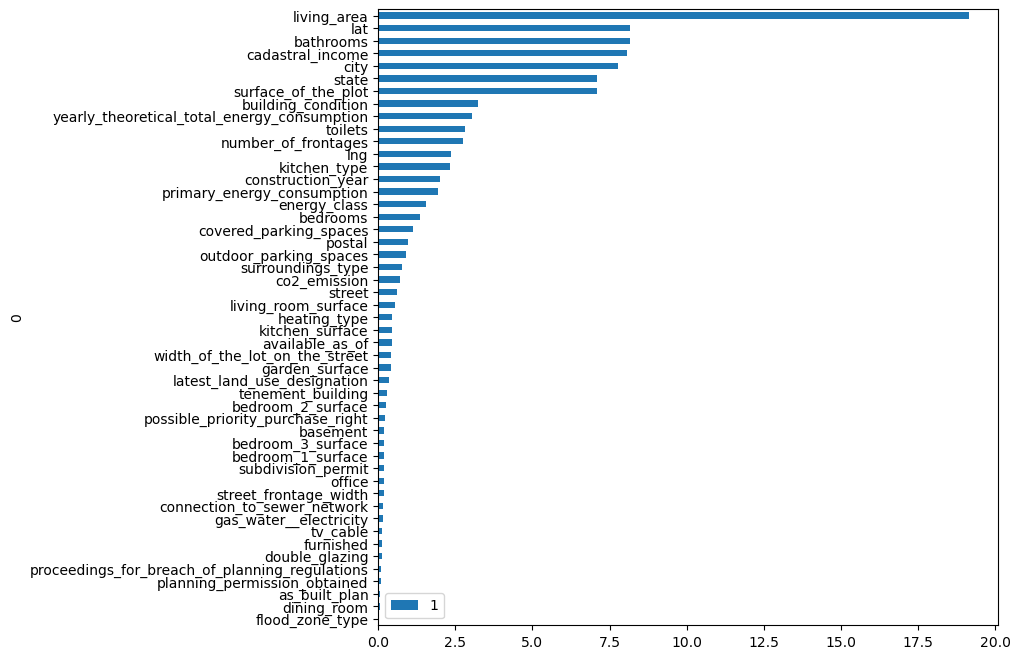

In [24]:
pd.concat(
    [pd.Series(model.feature_names_), pd.Series(model.feature_importances_)], axis=1
).sort_values(by=1).set_index(0).plot.barh(figsize=(8, 8))

# USe SHAP to explain feature importance

In [6]:
# def get_data(location, n_splits=10, n_repeats=1):
#     train = (
#         pd.read_csv(os.path.join(location, "train.csv"))
#         # .drop(columns = 'Id')
#     )

#     greeks = pd.read_csv(
#         "/home/studio-lab-user/ICR - Identifying Age-Related Conditions/greeks.csv"
#     ).drop(columns="Epsilon")
#     test = (
#         pd.read_csv(os.path.join(location, "test.csv"))
#         # .drop(columns = 'Id')
#         .assign(Class=-1)
#     )

#     submission = pd.read_csv(os.path.join(location, "sample_submission.csv"))

#     train = train.sample(frac=1, random_state=utils.CFG.seed).reset_index(drop=True)
#     train["folds"] = -1

#     cv = RepeatedMultilabelStratifiedKFold(
#         n_splits=n_splits, n_repeats=n_repeats, random_state=42
#     )
#     for f, (train_fold_index, val_fold_index) in enumerate(
#         cv.split(train.drop(columns="Class"), greeks.iloc[:, 1:-1])
#     ):
#         train.loc[val_fold_index, "folds"] = f + 1

#     return train, test, greeks, submission

In [7]:
# def run_catboost(train, test, pipeline):
#     # Create a numpy array to store out of folds predictions
#     oof_predictions = np.zeros(len(train))
#     oof_fold = np.zeros(len(train))
#     val_scores = np.zeros(len(set(train.folds.unique())))

#     for fold in tqdm(set(train.folds.unique())):
#         # identify features
#         # features = [x for x in train.columns if x not in ["Id", "Class", "folds"]] version 1
#         features = train.columns[~train.columns.str.contains("Id|Class|folds")]

#         # split folds
#         train_folds = train[train.folds != fold]
#         val_fold = train[train.folds == fold]

#         # get y
#         tr_y = train_folds.Class
#         val_y = val_fold.Class

#         # get X
#         tr_X = train_folds.loc[:, features]
#         val_X = val_fold.loc[:, features]

#         if pipeline is not None:
#             tr_X = pipeline.fit_transform(tr_X)
#             val_X = pipeline.transform(val_X)

#         # Re-identify feature names after transformations since the pipeline tends to rename the columns
#         categorical_features = [x for x in tr_X if tr_X[x].unique().shape[0] < 10]
#         features = [
#             x
#             for x in tr_X.columns
#             if x
#             not in np.array(tr_X.columns[tr_X.columns.str.contains("Id|Class|folds")])
#         ]
#         numerical = [x for x in features if x not in categorical_features]

#         for x in tr_X:
#             if tr_X[x].unique().shape[0] < 10 and x != "Class":
#                 tr_X[x] = tr_X[x].astype("str")
#                 val_X[x] = val_X[x].astype("str")

#         # get sample weights
#         train_w0, train_w1 = utils.calc_log_loss_weight(tr_y)
#         valid_w0, valid_w1 = utils.calc_log_loss_weight(val_y)

#         # create lightGBM dataset
#         catboost_train = catboost.Pool(
#             tr_X,
#             tr_y,
#             weight=tr_y.map({0: train_w0, 1: train_w1}),
#             cat_features=categorical_features,
#         )
#         catboost_valid = catboost.Pool(
#             val_X,
#             val_y,
#             weight=val_y.map({0: valid_w0, 1: valid_w1}),
#             cat_features=categorical_features,
#         )

#         # train model
#         model = catboost.CatBoostClassifier(**utils.CFG.cat_params_v2)
#         model.fit(
#             catboost_train,
#             eval_set=[catboost_valid],
#             early_stopping_rounds=utils.CFG.early_stopping_round,
#             verbose=utils.CFG.verbose,
#             use_best_model=True,
#         )
#         # calculate OOF validation predictions
#         valid_pred = model.predict_proba(val_X)[:, 1]

#         # append values
#         oof_predictions[val_fold.index] = valid_pred
#         oof_fold[val_fold.index] = fold

#         # calculate OOF scores
#         val_scores[fold - 1] = utils.balanced_log_loss(val_y, valid_pred)

#         del tr_X, val_X, tr_y, val_y, valid_pred, model
#         gc.collect()

#     oof_df = pd.DataFrame(
#         {
#             "Id": train["Id"],
#             utils.CFG.target_col: train[utils.CFG.target_col],
#             "prediction": oof_predictions,
#             "fold": oof_fold.astype(int),
#         }
#     )

#     return oof_df, val_scores